In [1]:
import os
import json
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image
from sklearn.model_selection import train_test_split


In [2]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold

In [3]:
# Import OS libraries
import os
import itertools

# Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report


# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,  BatchNormalization, Activation, Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

# from googleapiclient.discovery import build
# from google.oauth2.credentials import Credentials
# from googleapiclient.http import MediaFileUpload

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


# Check GPU availability
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is not available")

sns.set_style('whitegrid')

GPU is not available


In [4]:
# Diretório onde estão armazenadas as imagens sem ser separadas por pastas
image_dir = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\dataset'


In [5]:
def load_image(image_path, target_size=(224, 224)):
    try:
        image = Image.open(image_path)
        image = image.resize(target_size)  
        return np.array(image) / 255.0  
    except Exception as e:
        print(f"Erro ao carregar a imagem {image_path}: {e}")
        return None

In [6]:
# Carregar IDs do grupo de treinamento de um arquivo de texto
train_ids_file = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\training_lists\lower_resolution_train.txt'
with open(train_ids_file, 'r') as file:
    train_ids = [str(id) for id in json.loads(file.read())]

In [7]:
# Carregar IDs do grupo de validação de um arquivo de texto
val_ids_file = r'C:\Users\bruna\OneDrive - Universidade do Minho\Tese Mestrado em Bioinformática\AGAR_dataset\AGAR_dataset\training_lists\lower_resolution_val.txt'
with open(val_ids_file, 'r') as file:
    val_ids = [str(id) for id in json.loads(file.read())]

In [8]:
# Verificar se os IDs foram carregados corretamente
print(f"IDs de treinamento carregados: {train_ids[:5]} ... ({len(train_ids)} no total)")
print(f"IDs de validação carregados: {val_ids[:5]} ... ({len(val_ids)} no total)")

IDs de treinamento carregados: ['16078', '16831', '16073', '16072', '16830'] ... (3319 no total)
IDs de validação carregados: ['14175', '14176', '15540', '14172', '14678'] ... (1107 no total)


In [9]:
%%capture
# Lista para armazenar caminho da imagem e anotações correspondentes
train_data = []
val_data = []

# Iterar sobre todos os arquivos no diretório
for filename in os.listdir(image_dir):
    if filename.endswith('.json'):
        # Construir o caminho completo do arquivo JSON
        json_path = os.path.join(image_dir, filename)
        
        # Carregar o conteúdo do arquivo JSON
        with open(json_path, 'r') as file:
            try:
                json_data = json.load(file)
            except json.JSONDecodeError as e:
                print(f"Erro ao carregar JSON {json_path}: {e}")
                continue
        
        # Verificar se o sample_id está presente no JSON
        sample_id = str(json_data.get('sample_id', None))
        if sample_id is None:
            print(f"ID da amostra ausente no JSON: {json_path}")
            continue
        
        # Construir o caminho completo do arquivo de imagem
        image_filename = f"{sample_id}.jpg"
        image_path = os.path.join(image_dir, image_filename)
        
        # Verificar se o arquivo de imagem existe
        if not os.path.exists(image_path):
            print(f"Arquivo de imagem não encontrado: {image_path}")
            continue
        
        # Adicionar os dados à lista apropriada
        data_tuple = (image_path, json_data)
        if sample_id in train_ids:
            train_data.append(data_tuple)
            print(f"Imagem de treinamento encontrada e carregada: {image_path}")
        elif sample_id in val_ids:
            val_data.append(data_tuple)
            print(f"Imagem de validação encontrada e carregada: {image_path}")

In [10]:
# Verificar o número de imagens carregadas
print(f"Número de imagens de treinamento carregadas: {len(train_data)}")
print(f"Número de imagens de validação carregadas: {len(val_data)}")

Número de imagens de treinamento carregadas: 3318
Número de imagens de validação carregadas: 1106


In [11]:
# Separar as imagens e os rótulos (labels) para treinamento
train_images = [data[0] for data in train_data]
train_labels = [data[1]['classes'][0] for data in train_data]

In [12]:
# Separar as imagens e os rótulos (labels) para validação
val_images = [data[0] for data in val_data]
val_labels = [data[1]['classes'][0] for data in val_data]

In [13]:
# Verificar se as listas estão vazias
if len(train_images) == 0:
    print("Nenhuma imagem de treinamento foi carregada.")
if len(val_images) == 0:
    print("Nenhuma imagem de validação foi carregada.")

In [14]:
# Filtrar caminhos de imagem válidos
train_images = [img for img in train_images if img is not None]
val_images = [img for img in val_images if img is not None]

In [15]:
# Converter as imagens em tensores e normalizar, se necessário
train_images = [load_image(image_path, target_size=(224, 224)) for image_path in train_images]
val_images = [load_image(image_path, target_size=(224, 224)) for image_path in val_images]

In [16]:
# Verificar se alguma imagem falhou ao carregar
train_images = [img for img in train_images if img is not None]
val_images = [img for img in val_images if img is not None]

In [38]:
# Verificar o shape das imagens e dos rótulos antes da codificação
print("Shape de train_images antes da codificação:", np.array(train_images).shape)
print("Shape de train_labels antes da codificação:", np.array(train_labels).shape)
print("Shape de val_images antes da codificação:", np.array(val_images).shape)
print("Shape de val_labels antes da codificação:", np.array(val_labels).shape)

Shape de train_images antes da codificação: (2123, 224, 224, 3)
Shape de train_labels antes da codificação: (2123,)
Shape de val_images antes da codificação: (531, 224, 224, 3)
Shape de val_labels antes da codificação: (531,)


In [39]:
# Converter os rótulos em formato adequado (numérico), se necessário
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
val_labels = label_encoder.transform(val_labels)

In [40]:
# Verificar o número de classes
num_classes = len(label_encoder.classes_)
print(f"Número de classes: {num_classes}")


Número de classes: 5


In [41]:
# Dividir os dados em conjuntos de treinamento e validação
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Verificar os shapes dos dados após a divisão
print("Shape de train_images após a divisão:", np.array(train_images).shape)
print("Shape de train_labels após a divisão:", np.array(train_labels).shape)
print("Shape de val_images após a divisão:", np.array(val_images).shape)
print("Shape de val_labels após a divisão:", np.array(val_labels).shape)

Shape de train_images após a divisão: (1698, 224, 224, 3)
Shape de train_labels após a divisão: (1698,)
Shape de val_images após a divisão: (425, 224, 224, 3)
Shape de val_labels após a divisão: (425,)


In [42]:
# One-hot encoding dos rótulos após a divisão
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_labels.reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_labels.reshape(-1, 1))

# Verificar os shapes dos rótulos one-hot encoded
print("Shape de train_labels_one_hot após o one-hot encoding:", train_labels_one_hot.shape)
print("Shape de val_labels_one_hot após o one-hot encoding:", val_labels_one_hot.shape)

Shape de train_labels_one_hot após o one-hot encoding: (1698, 5)
Shape de val_labels_one_hot após o one-hot encoding: (425, 5)


In [43]:
#  Criar o modelo da CNN
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')  # Número de classes
])

In [44]:
#  Compilar o modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [45]:
# Treinar o modelo
history = model.fit(train_images, train_labels_one_hot, epochs=10, batch_size=32, 
                    validation_data=(val_images, val_labels_one_hot))

Epoch 1/10
54/54 [==============================] - 101s 2s/step - loss: 1.4150 - accuracy: 0.3681 - val_loss: 1.2976 - val_accuracy: 0.3506
Epoch 2/10
54/54 [==============================] - 95s 2s/step - loss: 1.2020 - accuracy: 0.4211 - val_loss: 1.2986 - val_accuracy: 0.3624
Epoch 3/10
54/54 [==============================] - 90s 2s/step - loss: 1.0151 - accuracy: 0.5554 - val_loss: 0.8861 - val_accuracy: 0.6188
Epoch 4/10
54/54 [==============================] - 91s 2s/step - loss: 0.8386 - accuracy: 0.6437 - val_loss: 0.6956 - val_accuracy: 0.7224
Epoch 5/10
54/54 [==============================] - 90s 2s/step - loss: 0.7001 - accuracy: 0.7126 - val_loss: 0.6347 - val_accuracy: 0.7012
Epoch 6/10
54/54 [==============================] - 92s 2s/step - loss: 0.5798 - accuracy: 0.7721 - val_loss: 0.6908 - val_accuracy: 0.7412
Epoch 7/10
54/54 [==============================] - 99s 2s/step - loss: 0.5759 - accuracy: 0.7833 - val_loss: 0.4035 - val_accuracy: 0.8776
Epoch 8/10
54/54 [=

In [46]:
#  Avaliar o modelo
val_loss, val_acc = model.evaluate(val_images, val_labels_one_hot, verbose=2)
print(f"Acurácia na validação: {val_acc * 100:.2f}%")

14/14 - 4s - loss: 0.3075 - accuracy: 0.9035 - 4s/epoch - 262ms/step
Acurácia na validação: 90.35%


In [65]:
model.save('trained_model.h5')

In [72]:
print("Model has been saved as 'trained_model.h5'")

Model has been saved as 'trained_model.h5'


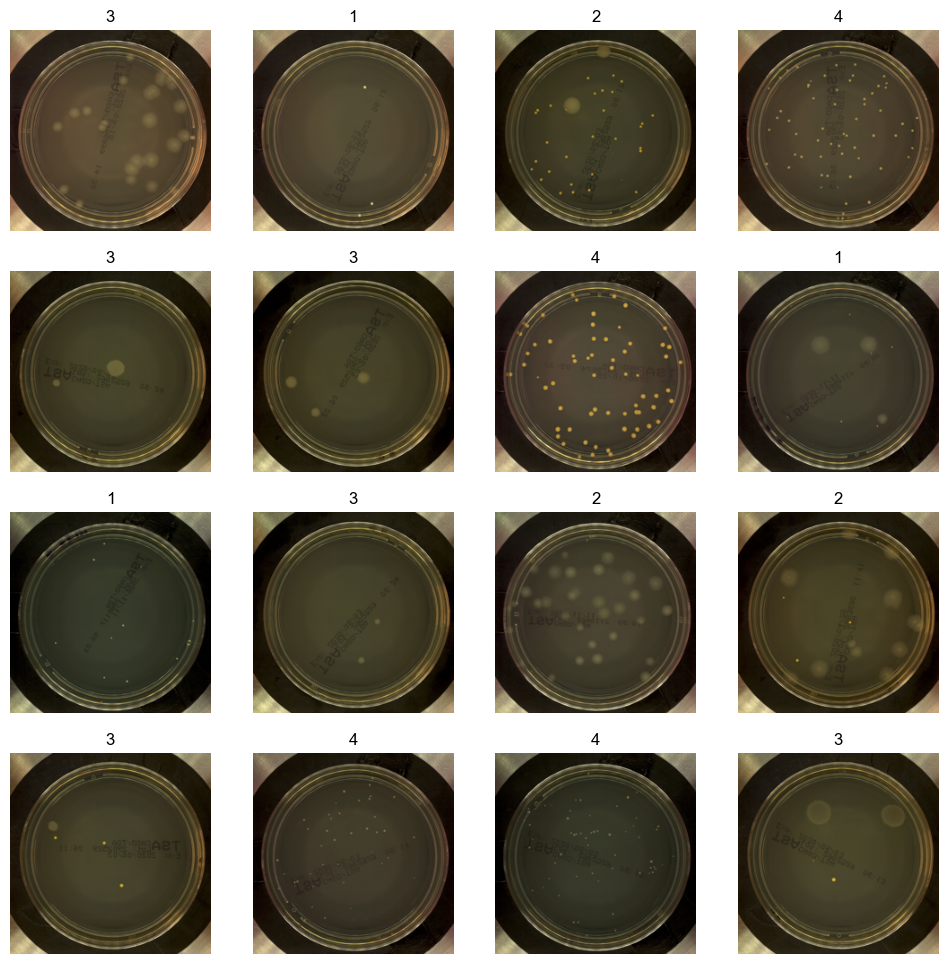

In [73]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Sample 16 random indices from the training data
sample_indices = random.sample(range(len(train_images_array)), 16)

# Extract the corresponding images and labels
sample_images = train_images_array[sample_indices]
sample_labels = train_labels_one_hot_array[sample_indices]

# Display the images and labels
plt.figure(figsize=(12, 12))
for i in range(16):
    image = sample_images[i]
    label_index = np.argmax(sample_labels[i]) 
    label = list(one_hot_encoder.categories_[0])[label_index]  # Extract the label name from the one-hot encoder

    plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(label, color='k', fontsize=12)
    plt.axis("off")

plt.show()


In [140]:
def predict_images(model, image_path, img_height, img_width):
    img = load_img(image_path, target_size=(img_height, img_width))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    prediction = model.predict(img_array)
    return prediction

In [141]:
def get_class_label(prediction, class_indices):
    max_prob_index = np.argmax(prediction)  # Encontra o índice da maior probabilidade
    class_label = list(class_indices.keys())[max_prob_index]  # Obtém a classe correspondente ao índice
    return class_label

In [142]:
from tensorflow.keras.models import load_model

# Carregar o modelo salvo
model = load_model('trained_model.h5')

In [143]:
import os

data_dir = r'C:\Users\bruna\OneDrive - Universidade do Minho\Microbialdataset\images'
if not os.path.exists(data_dir):
    print(f"Diretório {data_dir} não encontrado.")
else:
    print(f"Diretório {data_dir} encontrado.")


Diretório C:\Users\bruna\OneDrive - Universidade do Minho\Microbialdataset\images encontrado.


In [149]:
# Gerar um ImageDataGenerator para carregar imagens do diretório
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical')

Found 116293 images belonging to 6 classes.


In [150]:
class_indices = train_generator.class_indices

In [172]:
image_path = "C:\\Users\\bruna\\OneDrive - Universidade do Minho\\Microbialdataset\\images\\1\\class_1\\343_6.png"

In [173]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import load_model

prediction = predict_images(model, image_path, 224,224)
class_label = get_class_label(prediction, class_indices)

1/1 [==============================] - 0s 48ms/step


In [174]:
print(f"A imagem '{image_path}' foi classificada como '{class_label}' com probabilidade {np.max(prediction) * 100:.2f}%.")

A imagem 'C:\Users\bruna\OneDrive - Universidade do Minho\Microbialdataset\images\1\class_1\343_6.png' foi classificada como '1' com probabilidade 20.77%.


In [175]:
# Carregar a imagem usando load_img
img = load_img(image_path, target_size=(224, 224))

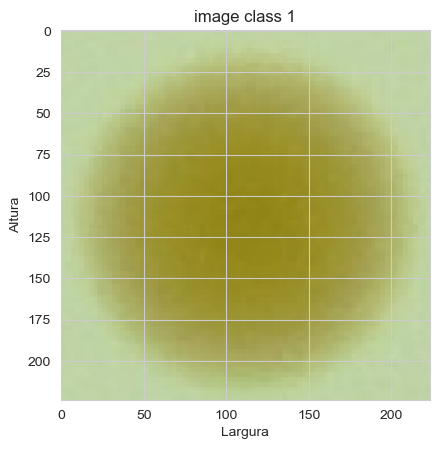

In [181]:
plt.imshow(img)
plt.title('image class 1')  # Adiciona um título
plt.xlabel('Largura')           # Rótulo para o eixo x
plt.ylabel('Altura')            # Rótulo para o eixo y
plt.show()